# Import packages and modules

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3
import patsy

# set seaborn style
sns.set(palette = "colorblind", font_scale = 2)

# Generate example dataset

In [92]:
# id
subject_id = list(range(120))

# group
group = np.repeat([1, 2, 3, 4], [30, 30, 30, 30])

# factors
factor1 = [{1: "A", 2: "A", 3: "B", 4: "B"}[x] for x in group]
factor2 = [{1: "A", 2: "B", 3: "A", 4: "B"}[x] for x in group]

# y
y = np.concatenate([np.random.normal(m, s, n) for m, s, n in zip([3, 4, 4, 3], [1, 1, 1, 1], [30, 30, 30, 30])])

# store in data frame
tutorial_data = pd.DataFrame({"subject_id": subject_id, "group": group, "factor1": factor1, "factor2": factor2, "y": y})

# see it
tutorial_data

,subject_id,group,factor1,factor2,y
0,0,1,A,A,3.197696
1,1,1,A,A,3.064073
2,2,1,A,A,2.368702
3,3,1,A,A,5.008001
4,4,1,A,A,1.338959
...,...,...,...,...,...
115,115,4,B,B,1.708474
116,116,4,B,B,2.241092
117,117,4,B,B,3.137197
118,118,4,B,B,2.667332


# Plot data, set expectations

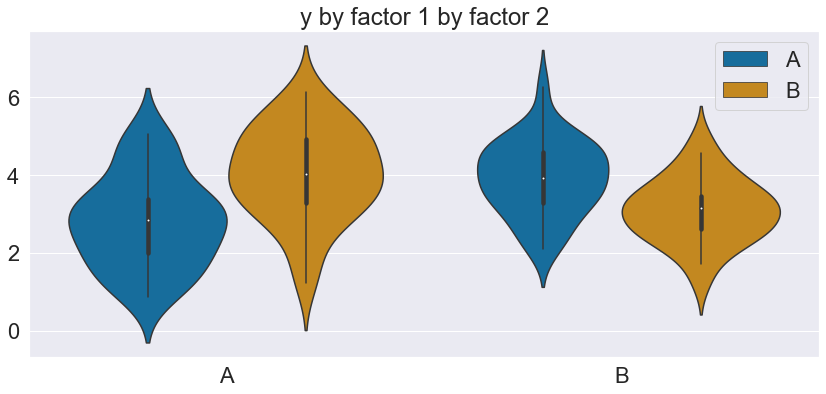

In [93]:
# figure
plt.figure(figsize = (12, 6))

# violin plot
sns.violinplot(x = "factor1", y = "y", hue = "factor2", data = tutorial_data)

# titles
plt.title("y by factor 1 by factor 2")
plt.xlabel(None)
plt.ylabel(None)

# legend
plt.legend(loc = "best")

# fix plot
plt.tight_layout()

# Models

## eta-squared function
$\eta^2 = \frac{SS_{Effect}}{SS_{Total}}$

In [94]:
def eta_squared(anova_lm_df):
    # total sum of squares
    sst = anova_lm_df["sum_sq"].sum()
    
    # add eta_squared to df
    anova_lm_df["eta_squared"] = [ss / sst for ss in anova_lm_df["sum_sq"]]
    
    # return df
    return anova_lm_df

## Dummy codes
Custom use of 0s and 1s so the coefficients can be interpreted as two main effects and an interaction

### The default

In [95]:
patsy.dmatrix("C(group, Treatment(reference = 0))", data = pd.DataFrame({"group": [1, 2, 3, 4]}))[:, :]

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.]])

### Used below

In [115]:
np.array([[1, 0, 0, 1], [1, 0, 1, 0], [1, 1, 0, 0], [1, 1, 1, 1]])

array([[1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 1]])

### Fit model

In [97]:
# index = 0 used as reference group
ols_fit1 = smf.ols("y ~ C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [98]:
ols_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     10.22
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           5.03e-06
Time:                        11:48:38   Log-Likelihood:                -173.31
No. Observations:                 120   AIC:                             354.6
Df Residuals:                     116   BIC:                             365.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           3.8356      0.190     20.139      0.000       3.458       4.213
C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])[custom0]     0.0844      0.190      0.443      0.658      -0.293       0.462
C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])[custom1]     0.2037      0.190      1.069      0.287      -0.174       0.581
C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])[custom2]    -1.0314      0.190     -5.415      0.000      -1.409      -0.654
==============================================================================
Omnibus:                        0.077   Durbin-Watson:                   2.320
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.230
Skew:                          -0.027   Prob(JB):                        0.891
Kurtosis:                       2.792   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [99]:
eta_squared(
    sm.stats.anova_lm(ols_fit1, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])",3.0,33.370892,11.123631,10.22219,0.000005,0.20909
Residual,116.0,126.229428,1.088185,NaN,NaN,0.79091


## Custom codes

In [100]:
np.array([[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])

array([[-0.5, -0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [ 0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5]])

### Fit model

In [101]:
# index = 0 used as reference group
ols_fit2 = smf.ols("y ~ C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [102]:
ols_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     10.22
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           5.03e-06
Time:                        11:48:38   Log-Likelihood:                -173.31
No. Observations:                 120   AIC:                             354.6
Df Residuals:                     116   BIC:                             365.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         3.4640      0.095     36.376      0.000       3.275       3.653
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom0]     0.0844      0.190      0.443      0.658      -0.293       0.462
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom1]     0.2037      0.190      1.069      0.287      -0.174       0.581
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom2]    -1.0314      0.190     -5.415      0.000      -1.409      -0.654
==============================================================================
Omnibus:                        0.077   Durbin-Watson:                   2.320
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.230
Skew:                          -0.027   Prob(JB):                        0.891
Kurtosis:                       2.792   Cond. No.                         2.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [103]:
eta_squared(
    sm.stats.anova_lm(ols_fit2, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])",3.0,33.370892,11.123631,10.22219,0.000005,0.20909
Residual,116.0,126.229428,1.088185,NaN,NaN,0.79091


## Custom codes using factor1 and factor2 variables

In [104]:
np.array([[-0.5], [0.5]])

array([[-0.5],
       [ 0.5]])

### Fit model

In [105]:
# index = 0 used as reference group
ols_fit3 = smf.ols("y ~ C(factor1, [[-0.5], [0.5]]) * C(factor2, [[-0.5], [0.5]])", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [106]:
ols_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     10.22
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           5.03e-06
Time:                        11:48:38   Log-Likelihood:                -173.31
No. Observations:                 120   AIC:                             354.6
Df Residuals:                     116   BIC:                             365.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     3.4640      0.095     36.376      0.000       3.275       3.653
C(factor1, [[-0.5], [0.5]])[custom0]                                          0.0844      0.190      0.443      0.658      -0.293       0.462
C(factor2, [[-0.5], [0.5]])[custom0]                                          0.2037      0.190      1.069      0.287      -0.174       0.581
C(factor1, [[-0.5], [0.5]])[custom0]:C(factor2, [[-0.5], [0.5]])[custom0]    -2.0628      0.381     -5.415      0.000      -2.817      -1.308
==============================================================================
Omnibus:                        0.077   Durbin-Watson:                   2.320
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.230
Skew:                          -0.027   Prob(JB):                        0.891
Kurtosis:                       2.792   Cond. No.                         4.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [107]:
eta_squared(
    sm.stats.anova_lm(ols_fit3, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(factor1, [[-0.5], [0.5]])",1.0,0.213890,0.213890,0.196557,6.583405e-01,0.001340
"C(factor2, [[-0.5], [0.5]])",1.0,1.244520,1.244520,1.143666,2.870993e-01,0.007798
"C(factor1, [[-0.5], [0.5]]):C(factor2, [[-0.5], [0.5]])",1.0,31.912482,31.912482,29.326346,3.352664e-07,0.199952
Residual,116.0,126.229428,1.088185,NaN,NaN,0.790910


## Effect code main effects and interactions as float predictors

In [108]:
effect1 = [{1: -0.5, 2: -0.5, 3: 0.5, 4: 0.5}[x] for x in group]
effect2 = [{1: -0.5, 2: 0.5, 3: -0.5, 4: 0.5}[x] for x in group]
interaction = [{1: 0.5, 2: -0.5, 3: -0.5, 4: 0.5}[x] for x in group]

## Fit bayesian GLM with student t priors
Prior choices loosely based on [Prior Choice Recommendations from Andrew Gelman](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

In [109]:
with pymc3.Model() as tutorial_model:
    # define priors, mean = 0, sd = 1, df = 10
    priors = {"Intercept": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "effect1": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "effect2": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "interaction": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10)}
    
    # model formula
    pymc3.GLM.from_formula("y ~ effect1 + effect2 + interaction", data = tutorial_data, priors = priors)
    
    # sample
    tutorial_trace = pymc3.sample(draws = 2000, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, interaction, effect2, effect1, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


### Trace plots

/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


<Figure size 1008x504 with 0 Axes>

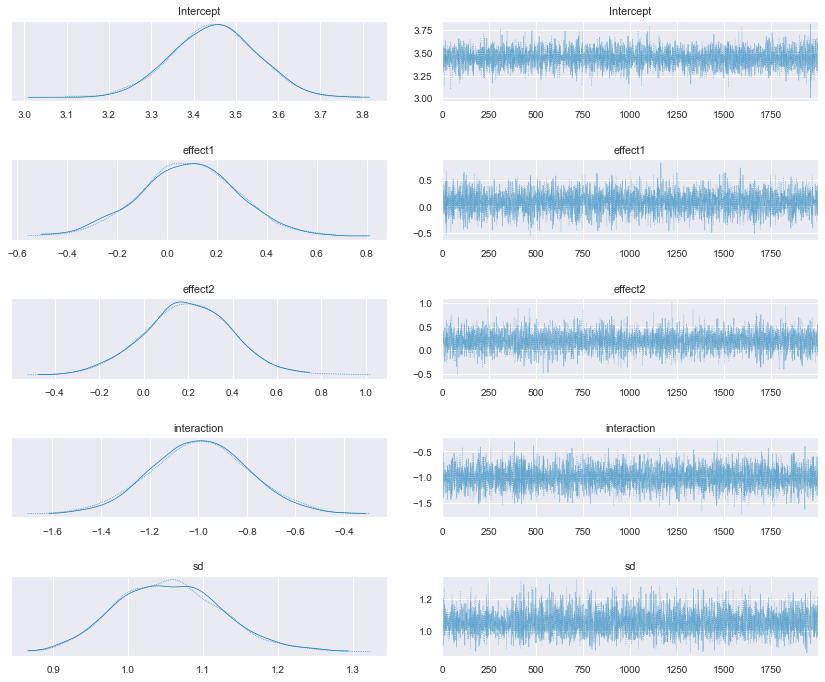

In [110]:
# figure
plt.figure(figsize = (14, 7))

# trace plot
pymc3.traceplot(tutorial_trace)

# fix plot
plt.tight_layout();

### Summary of results

In [111]:
pymc3.summary(tutorial_trace, hdi_prob = 0.95)

/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,3.448,0.098,3.260,3.638,0.001,0.001,6961.0,6948.0,6976.0,2677.0,1.0
effect1,0.084,0.192,-0.319,0.436,0.002,0.003,6586.0,2208.0,6572.0,2527.0,1.0
effect2,0.197,0.195,-0.199,0.568,0.003,0.002,5756.0,3923.0,5817.0,3290.0,1.0
interaction,-0.995,0.197,-1.371,-0.600,0.002,0.002,7166.0,6757.0,7140.0,3411.0,1.0
sd,1.055,0.071,0.909,1.187,0.001,0.001,6296.0,6293.0,6175.0,3025.0,1.0


### Linear regression results for comparison

In [112]:
ols_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     10.22
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           5.03e-06
Time:                        11:48:51   Log-Likelihood:                -173.31
No. Observations:                 120   AIC:                             354.6
Df Residuals:                     116   BIC:                             365.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         3.4640      0.095     36.376      0.000       3.275       3.653
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom0]     0.0844      0.190      0.443      0.658      -0.293       0.462
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom1]     0.2037      0.190      1.069      0.287      -0.174       0.581
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom2]    -1.0314      0.190     -5.415      0.000      -1.409      -0.654
==============================================================================
Omnibus:                        0.077   Durbin-Watson:                   2.320
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.230
Skew:                          -0.027   Prob(JB):                        0.891
Kurtosis:                       2.792   Cond. No.                         2.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Compare sd in trace plots to mean square residual in ANOVA source table

In [113]:
sm.stats.anova_lm(ols_fit2, type = 3)

,df,sum_sq,mean_sq,F,PR(>F)
"C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])",3.0,33.370892,11.123631,10.22219,0.000005
Residual,116.0,126.229428,1.088185,NaN,NaN
